# STEP-1 
Importing the required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,MaxPooling2D,Conv2D,Flatten,Dropout
from keras.utils import to_categorical
import cv2
import os

# STEP-2 
Load the dataset

In [2]:
data_path = "D:\TB_Chest_Radiography_Database"

In [3]:
from keras.preprocessing.image import ImageDataGenerator

In [4]:
import pathlib
import shutil

In [5]:
data_dir = pathlib.Path(data_path)

In [6]:
img_count = len(list(data_dir.glob('*/*.png')))
img_count

4200

In [7]:
data = os.listdir(data_path)

In [8]:
print(data)

['Normal', 'Normal.metadata.xlsx', 'README.md.txt', 'Tuberculosis', 'Tuberculosis.metadata.xlsx']


In [9]:
img_types = {
    'Normal': list(data_dir.glob('Normal/*.png')),
    'Tuberculosis': list(data_dir.glob('Tuberculosis/*.png'))
}

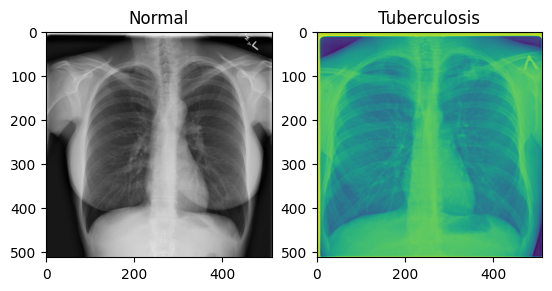

In [10]:
import matplotlib.image as mpimg
fig, axs = plt.subplots(1,2)
i = 0
for key, value in img_types.items():
    img = mpimg.imread(str(img_types[key][3]))
    axs[i].imshow(img)
    axs[i].set_title(key)
    i+=1

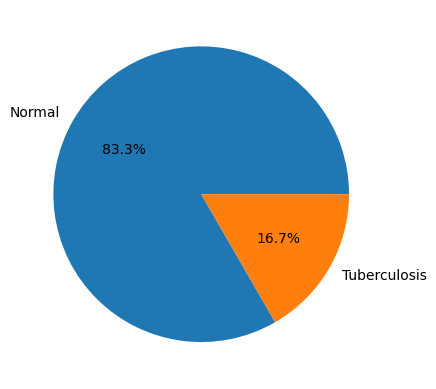

In [11]:
labels = ['Normal', 'Tuberculosis']
size = [len(img_types['Normal']), len(img_types['Tuberculosis'])]
plt.pie(size, labels=labels, autopct='%1.1f%%')
plt.show()

In [12]:
# Calculate the number of samples in each class
num_normal = len(img_types['Normal'])
num_tb = len(img_types['Tuberculosis'])

# Determine the minority and majority class
if num_normal < num_tb:
    minority_class = 'Normal'
    majority_class = 'Tuberculosis'
    minority_count = num_normal
    majority_count = num_tb
else:
    minority_class = 'Tuberculosis'
    majority_class = 'Normal'
    minority_count = num_tb
    majority_count = num_normal

# Randomly select samples from the majority class to balance the dataset
random_indices = np.random.choice(range(majority_count), size=minority_count, replace=False)
balanced_majority_samples = np.array(img_types[majority_class])[random_indices]

# Update the image types dictionary with the balanced data
img_types[minority_class] = np.array(img_types[minority_class])
img_types[majority_class] = balanced_majority_samples

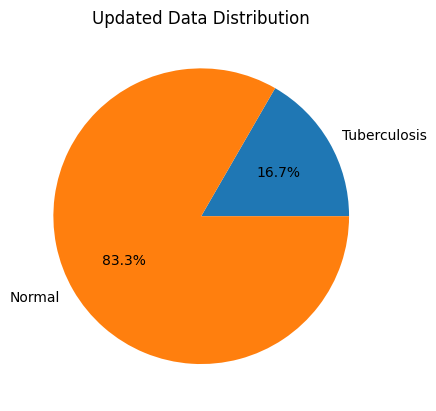

In [13]:
# Plot the updated data
labels = [minority_class, majority_class]
size = [minority_count, majority_count]
plt.pie(size, labels=labels, autopct='%1.1f%%')
plt.title('Updated Data Distribution')
plt.show()


In [14]:
from sklearn.utils import class_weight
# Set the image size and batch size
image_size = (224, 224)
batch_size = 32

# Create the image data generator
data_generator = ImageDataGenerator(rescale=1./255)

# Generate the image data for the balanced dataset
unbalanced_image_data = data_generator.flow_from_directory(
    data_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training',
    classes=img_types.keys()
)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(unbalanced_image_data.classes),
    y=unbalanced_image_data.classes
)

Found 4200 images belonging to 2 classes.


In [15]:
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [16]:
# Generate the image data for the balanced dataset
balanced_image_data = data_generator.flow_from_directory(
    data_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training',
    classes=img_types.keys()
)

Found 4200 images belonging to 2 classes.


In [17]:
from keras.layers import BatchNormalization

In [23]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3),batch_size=batch_size))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (32, 222, 222, 16)        448       
                                                                 
 batch_normalization_8 (Bat  (32, 222, 222, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 111, 111, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 109, 109, 32)        4640      
                                                                 
 batch_normalization_9 (Bat  (32, 109, 109, 32)        128       
 chNormalization)                                                
                                                      

In [24]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [25]:
model.fit_generator(balanced_image_data,
                    epochs=10,
                    class_weight=class_weights_dict)

C:\Users\vigne\AppData\Local\Temp\ipykernel_16524\547159943.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(balanced_image_data,


Epoch 1/10
132/132 [==============================] - 171s 1s/step - loss: 0.1695 - accuracy: 0.9355
Epoch 2/10
132/132 [==============================] - 183s 1s/step - loss: 0.0772 - accuracy: 0.9714
Epoch 3/10
132/132 [==============================] - 152s 1s/step - loss: 0.0488 - accuracy: 0.9848
Epoch 4/10
132/132 [==============================] - 133s 1s/step - loss: 0.0537 - accuracy: 0.9831
Epoch 5/10
132/132 [==============================] - 138s 1s/step - loss: 0.0348 - accuracy: 0.9893
Epoch 6/10
132/132 [==============================] - 156s 1s/step - loss: 0.0159 - accuracy: 0.9974
Epoch 7/10
132/132 [==============================] - 154s 1s/step - loss: 0.0305 - accuracy: 0.9890
Epoch 8/10
132/132 [==============================] - 156s 1s/step - loss: 0.0158 - accuracy: 0.9952
Epoch 9/10
132/132 [==============================] - 146s 1s/step - loss: 0.0098 - accuracy: 0.9971
Epoch 10/10
132/132 [==============================] - 151s 1s/step - loss: 0.0074 - accura

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
accuracy_score = model.evaluate_generator(balanced_image_data)[1]

In [31]:
print("Accuracy Score:", accuracy_score)

Accuracy Score: 0.994500515
